In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#from _future_ import printfunction,unicode literals
import json
import requests
import xlrd
import openpyxl

In [3]:
RANDOM_SEED = 20090425

In [6]:
bj_senti = pd.read_csv("data/Key-Word Beijing Smog_senti.csv")

bj_senti

,time,positive,negative
0,今天06:26,0.555918,0.444082
1,2019/4/14,0.961942,0.038058
2,2019/4/14,0.531556,0.468444
3,2019/4/14,0.872537,0.127463
4,2019/4/14,0.334453,0.665547
...,...,...,...
1033,2019/4/7,0.087214,0.912786
1034,2019/4/7,0.624884,0.375116
1035,2019/4/7,0.022451,0.977549
1036,2019/4/6,0.182185,0.817815


In [47]:
bj_senti_mean = bj_senti.mean()
bj_senti_mean

positive    0.590099
negative    0.409901
dtype: float64

In [48]:
bj_senti_var = bj_senti.var()
bj_senti_var

positive    0.097683
negative    0.097683
dtype: float64

In [49]:
bj_senti.positive

0       0.555918
1       0.961942
2       0.531556
3       0.872537
4       0.334453
          ...   
1033    0.087214
1034    0.624884
1035    0.022451
1036    0.182185
1037    0.900554
Name: positive, Length: 1038, dtype: float64

bj_senti = bj_senti.set_index('time')
bj_senti.head(50)

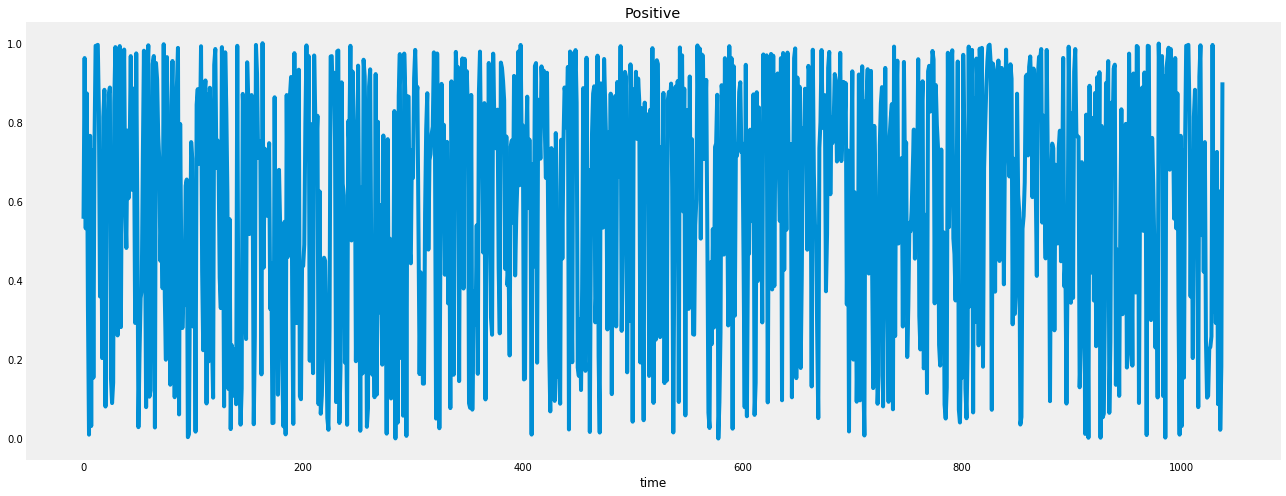

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,8))
plt.plot(bj_senti.positive)
plt.title('Positive')
# plt.ylabel('')
plt.xlabel('time')
plt.grid(False)
plt.show()

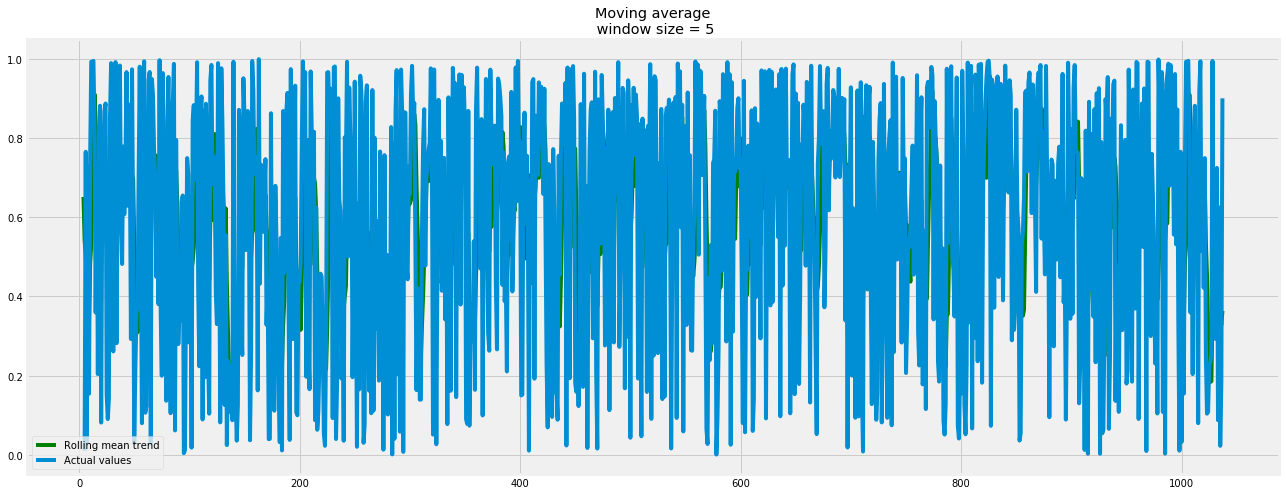

In [51]:
def plot_moving_average(series,window,plot_intervals=False, scale =1.96):
    rolling_mean = series.rolling(window=window).mean()
 
    plt.figure(figsize=(20,8))
    plt.title('Moving average\n window size = {}'.format(window))
    #smaller window, more details; more bigger window, you can see the plot
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    #plt.plot(lwd = 1)

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

#Smooth by the previous 5 days (by week)
plot_moving_average(bj_senti.positive, 5)

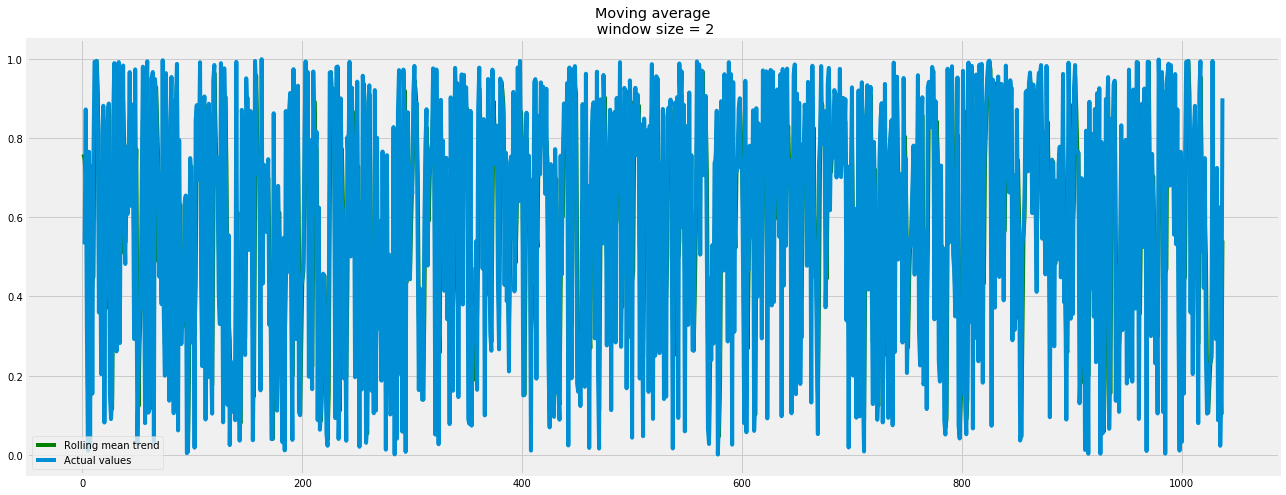

In [52]:
plot_moving_average(bj_senti.positive, 2)

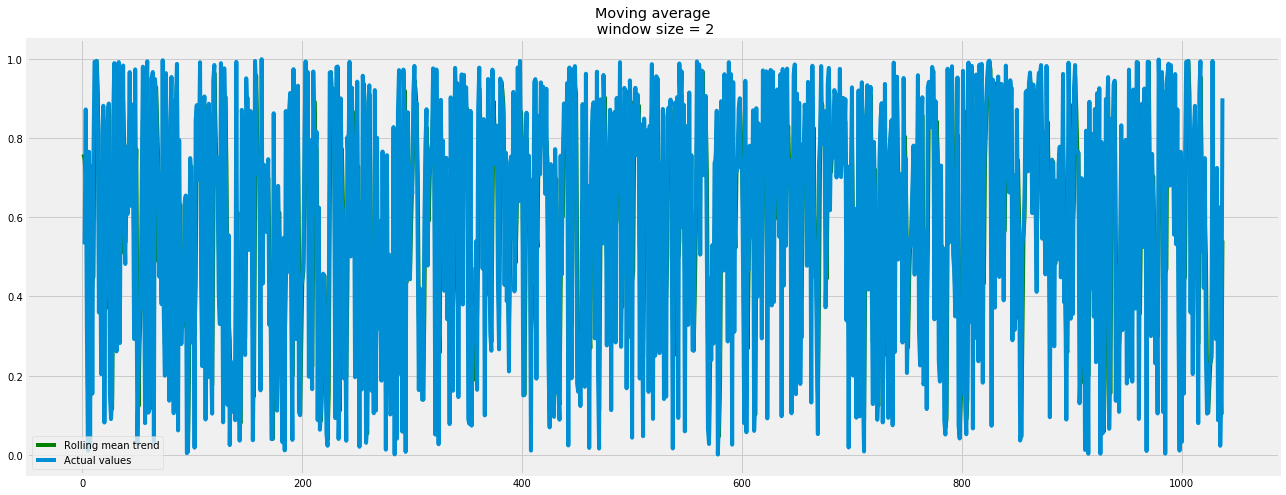

In [53]:
plot_moving_average(bj_senti.positive, 2, plot_intervals=False)

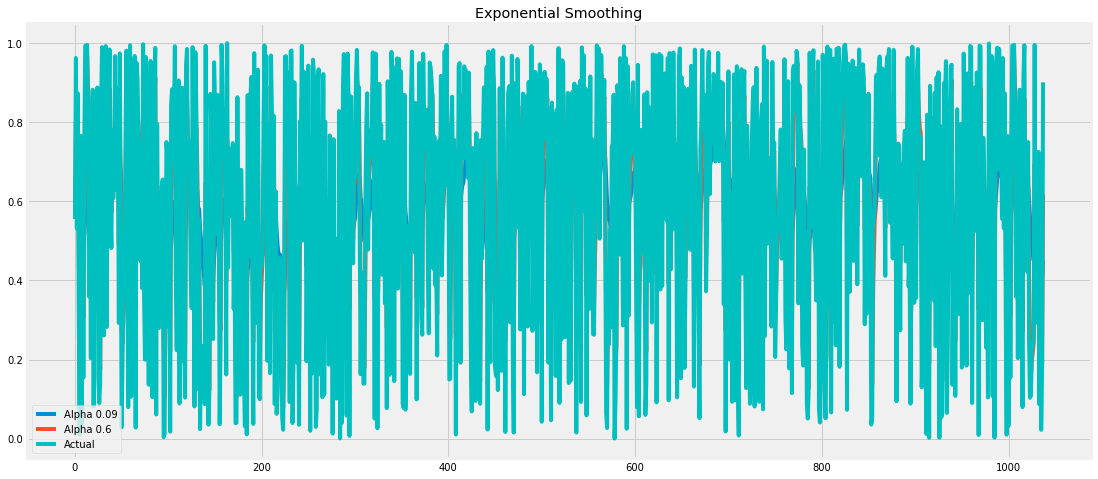

In [54]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
        
plot_exponential_smoothing(bj_senti.positive, [0.09, 0.6])

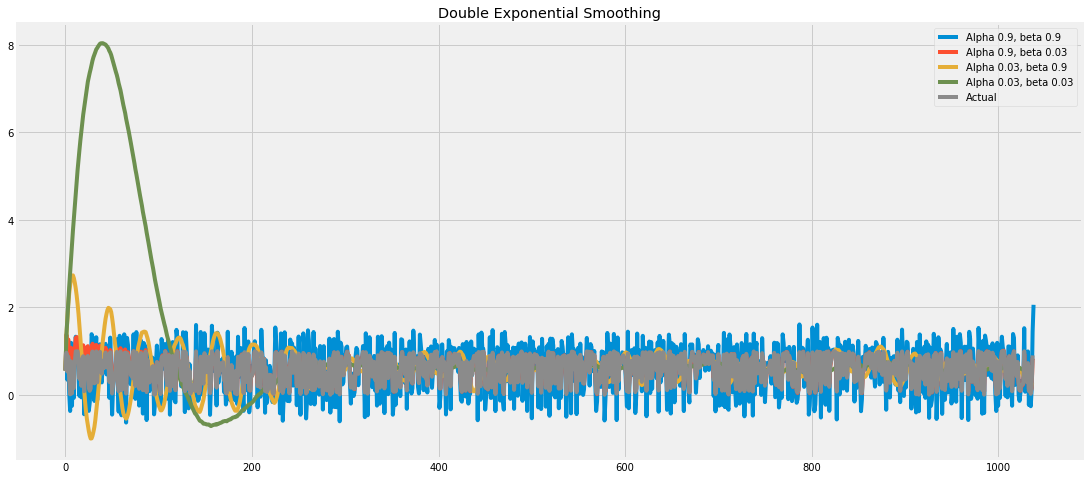

In [55]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(bj_senti.positive, alphas=[0.9, 0.03], betas=[0.9, 0.03])

In [56]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [57]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Positive Value')
    plt.plot(predicted, color='blue',label='Predicted Positive Value')
    plt.title('Positive Value Prediction')
    plt.xlabel('Time')
    plt.ylabel('Positive Value')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))


In [58]:
# First, we get the data
dataset = pd.read_csv('data/Key-Word Beijing Smog_senti.csv', index_col='time', parse_dates=['time'])
dataset = dataset.sort_values(by="time" , ascending=True)
dataset

,positive,negative
time,,
2019/1/19,0.984697,0.015303
2019/1/20,0.679756,0.320244
2019/1/21,0.988013,0.011987
2019/2/1,0.960208,0.039792
2019/2/24,0.916842,0.083158
...,...,...
2019/4/9,0.709776,0.290224
26分钟前,0.782039,0.217961
56分钟前,0.805995,0.194005


In [59]:
dataset["newindex"] = range(len(dataset))
dataset

,positive,negative,newindex
time,,,
2019/1/19,0.984697,0.015303,0
2019/1/20,0.679756,0.320244,1
2019/1/21,0.988013,0.011987,2
2019/2/1,0.960208,0.039792,3
2019/2/24,0.916842,0.083158,4
...,...,...,...
2019/4/9,0.709776,0.290224,1033
26分钟前,0.782039,0.217961,1034
56分钟前,0.805995,0.194005,1035


In [60]:
dataset = dataset.set_index('newindex')
dataset

,positive,negative
newindex,,
0,0.984697,0.015303
1,0.679756,0.320244
2,0.988013,0.011987
3,0.960208,0.039792
4,0.916842,0.083158
...,...,...
1033,0.709776,0.290224
1034,0.782039,0.217961
1035,0.805995,0.194005


In [61]:
# Checking for missing values
training_set = dataset[:800].iloc[:,:-1].values
test_set = dataset[800:].iloc[:,:-1].values
training_set.shape

(800, 1)

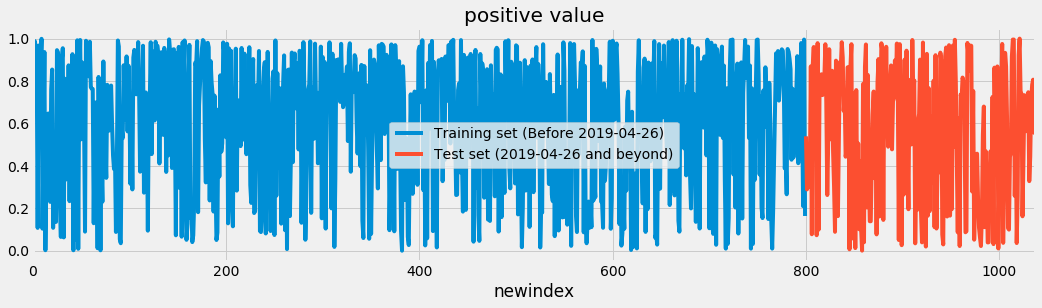

In [62]:
dataset["positive"][:800].plot(figsize=(16,4),legend=True)
dataset["positive"][800:].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2019-04-26)','Test set (2019-04-26 and beyond)'])
plt.title('positive value')
plt.show()

In [63]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(30,800):
    X_train.append(training_set[i-30:i,0])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [64]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [65]:
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
770/770 [==============================] - 2s 3ms/step - loss: 0.1399
Epoch 2/50
770/770 [==============================] - 1s 1ms/step - loss: 0.1051
Epoch 3/50
770/770 [==============================] - 1s 1ms/step - loss: 0.1171
Epoch 4/50
770/770 [==============================] - 1s 1ms/step - loss: 0.1083
Epoch 5/50
770/770 [==============================] - 1s 1ms/step - loss: 0.1115
Epoch 6/50
770/770 [==============================] - 1s 1ms/step - loss: 0.1085
Epoch 7/50
770/770 [==============================] - 1s 1ms/step - loss: 0.1063
Epoch 8/50
770/770 [==============================] - 1s 1ms/step - loss: 0.1018
Epoch 9/50
770/770 [==============================] - 1s 1ms/step - loss: 0.1005
Epoch 10/50
770/770 [==============================] - 1s 1ms/step - loss: 0.1023
Epoch 11/50
770/770 [==============================] - 1s 1ms/step - loss: 0.1003
Epoch 12/50
770/770 [==============================] - 1s 1ms/step - loss: 0.1008
Epoch 13/50
770/770 [====

In [66]:
sc = MinMaxScaler(feature_range=(0,1))
training_set = sc.fit_transform(training_set)
training_set

array([[0.98609395],
       [0.68060618],
       [0.98941615],
       [0.96156082],
       [0.91811721],
       [0.10765703],
       [0.96826998],
       [0.72310165],
       [0.85439159],
       [1.        ],
       [0.10395826],
       [0.49244496],
       [0.93761286],
       [0.00231555],
       [0.33430435],
       [0.29988067],
       [0.64760815],
       [0.48646586],
       [0.23039211],
       [0.76122603],
       [0.85498155],
       [0.10799025],
       [0.44633653],
       [0.47868904],
       [0.13589475],
       [0.94649698],
       [0.93683397],
       [0.85020828],
       [0.24433586],
       [0.06504204],
       [0.8999619 ],
       [0.95556578],
       [0.06284015],
       [0.81187665],
       [0.3354192 ],
       [0.80307816],
       [0.34925375],
       [0.87478402],
       [0.23371708],
       [0.77748124],
       [0.45602713],
       [0.92755318],
       [0.00207651],
       [0.91487998],
       [0.05372563],
       [0.79135718],
       [0.99297302],
       [0.008

In [67]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["positive"][:800],dataset["positive"][800:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 30:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)
inputs

array([[8.69289408e-01],
       [9.42177214e-01],
       [7.08415304e-01],
       [7.86956373e-01],
       [8.57853304e-01],
       [9.50516431e-01],
       [9.43069300e-01],
       [8.03679805e-01],
       [3.88229370e-01],
       [4.32107357e-01],
       [2.66259135e-01],
       [9.51816610e-01],
       [9.38622767e-01],
       [9.05318294e-01],
       [8.56529135e-01],
       [4.29259973e-01],
       [7.64535183e-01],
       [4.39543970e-01],
       [5.46662316e-01],
       [7.39195969e-01],
       [7.54650508e-01],
       [9.18076333e-01],
       [4.12944428e-01],
       [5.57196547e-01],
       [6.49614098e-01],
       [9.79968030e-01],
       [6.41188514e-01],
       [2.10355051e-01],
       [9.96424987e-01],
       [1.63802811e-01],
       [5.39776496e-01],
       [2.89309994e-01],
       [3.72736772e-01],
       [3.01824050e-01],
       [3.79724992e-01],
       [8.69908274e-01],
       [7.76245945e-02],
       [8.75684562e-01],
       [9.61247945e-01],
       [7.01527266e-01],


In [68]:
test_set.shape

(238, 1)

In [69]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(30,268):
    X_test.append(inputs[i-30:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_positive_value = regressor.predict(X_test)
predicted_positive_value = sc.inverse_transform(predicted_positive_value)

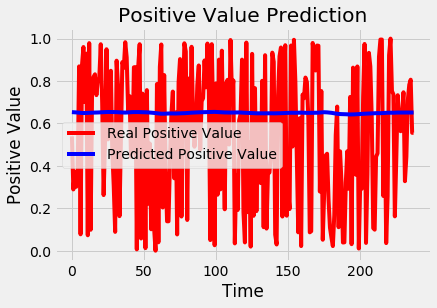

In [70]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_positive_value)

In [71]:
# Evaluating our model
return_rmse(test_set,predicted_positive_value)

The root mean squared error is 0.33420365679267294.
